## import

In [1]:
from pathlib import Path

import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import PspNet
from torchlake.semantic_segmentation.models.pspnet.loss import PspLoss
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/pspnet")
data_path = Path("../../data")

In [3]:
device = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)


In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


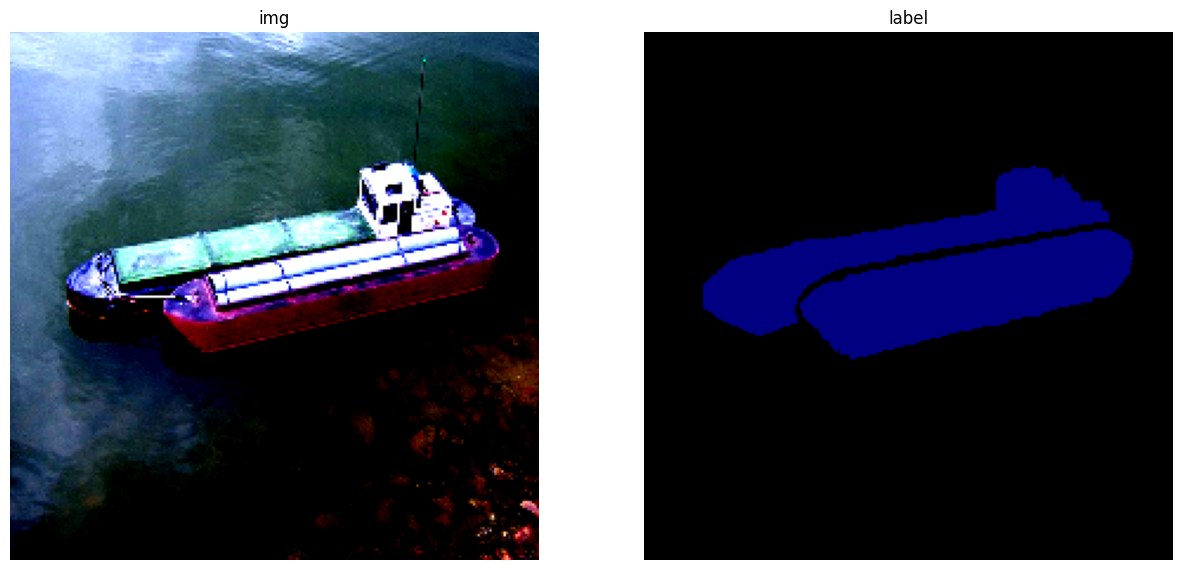

In [8]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [9]:
model = PspNet(2048, 20 + 1).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
PspNet                                        --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottleneck: 3-9                   1,117,184
│    │    └─Bo

In [11]:
model_path = artifacts_path.joinpath('pspnet.pth')

# train

In [12]:
criterion = PspLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
EPOCHES = 30

In [14]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)
        label = label.long().to(device)

        output = model(img)
        loss = criterion(*output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"epoch {e+1}: {running_loss/len(train_dataset)}")


100%|██████████| 91/91 [00:44<00:00,  2.03it/s]


epoch 1: 0.03490248114801624


100%|██████████| 91/91 [00:43<00:00,  2.08it/s]


epoch 2: 0.021636108884768843


100%|██████████| 91/91 [00:44<00:00,  2.06it/s]


epoch 3: 0.018242645685180862


100%|██████████| 91/91 [00:43<00:00,  2.10it/s]


epoch 4: 0.014620773333108511


100%|██████████| 91/91 [00:43<00:00,  2.12it/s]


epoch 5: 0.013354579669030475


100%|██████████| 91/91 [00:43<00:00,  2.12it/s]


epoch 6: 0.011421846168948906


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


epoch 7: 0.010127039021984065


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


epoch 8: 0.009841298109634692


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


epoch 9: 0.0097973915389261


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


epoch 10: 0.007978555634796845


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


epoch 11: 0.007564527694605242


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 12: 0.006349963996363717


100%|██████████| 91/91 [00:43<00:00,  2.12it/s]


epoch 13: 0.005392014878008155


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 14: 0.005334239415990664


100%|██████████| 91/91 [00:43<00:00,  2.12it/s]


epoch 15: 0.004832433075623295


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 16: 0.004866781689602609


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 17: 0.004454764999497849


100%|██████████| 91/91 [00:43<00:00,  2.12it/s]


epoch 18: 0.006617937100187348


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 19: 0.014798664786829558


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 20: 0.010337477307568455


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 21: 0.006930129734912444


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 22: 0.005038189795411742


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 23: 0.004336870436892655


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 24: 0.0038180457708805317


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 25: 0.0034912321173035726


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 26: 0.0033089691012780607


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 27: 0.003137040181213992


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 28: 0.0030030385913040235


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]


epoch 29: 0.0029114915017733


100%|██████████| 91/91 [00:43<00:00,  2.11it/s]

epoch 30: 0.002842119803164286


In [25]:
# torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), "fcn.onnx")
torch.save(model.state_dict(), model_path)

In [26]:
get_file_size(model_path)

194

# inference

In [17]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [19]:
test_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### dice coef

In [21]:
model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(21):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 92/92 [00:44<00:00,  2.05it/s]


In [22]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.7793244
bicycle 0.41504517
bird 0.82137513
boat 0.7704025
bottle 0.7313216
bus 0.76926214
car 0.9096786
cat 0.89627945
chair 0.75394773
cow 0.67072016
diningtable 0.7664631
dog 0.88694483
horse 0.75447065
motorbike 0.70990103
person 0.93331563
pottedplant 0.64644164
sheep 0.6621465
sofa 0.8281943
train 0.8104403
tvmonitor 0.72050774
mean dice: 0.7618091


### for image in dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


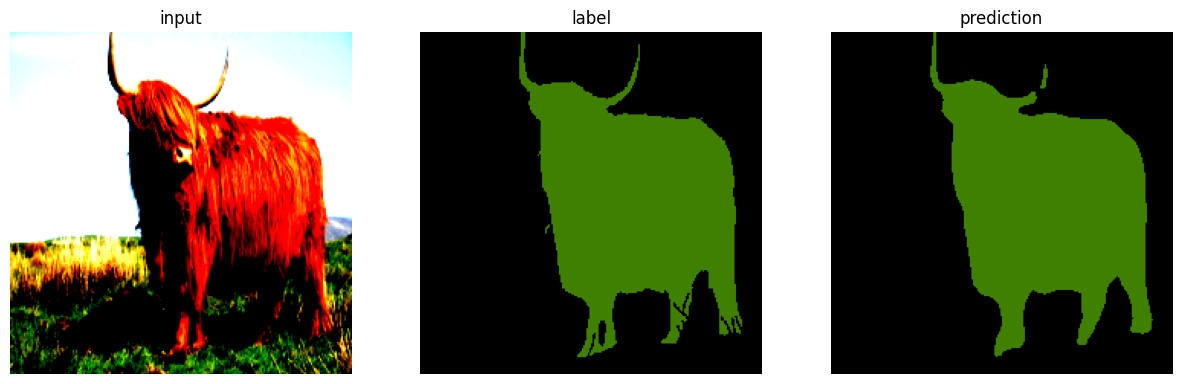

In [23]:
interest_pic = 1523

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(device))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

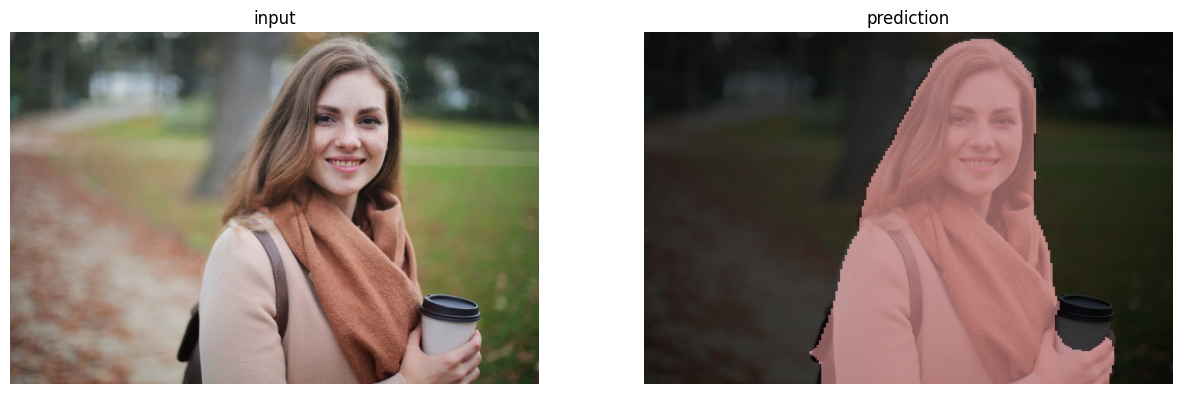

In [24]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(device))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )